# Deep Convolutional Generative Adversarial Network

A DCGAN is a direct extension of the GAN , except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. 

It was first described by Radford et. al. in the paper Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial Networks <https://arxiv.org/pdf/1511.06434.pdf>. 

The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a probability that the input is from the data distribution. 

The generator is comprised of convolutional-transpose layers, batch norm layers,and ReLU activations. The input is a latent vector z. z is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. 

Coded by following https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [27]:
# import the relevant packages

import torch
from torch import nn,optim
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.nn.parallel

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [28]:
img_size = 64
IMG_PATH = 'celeba'
ngpu = 1 # number of gpu's

datas_transform = transforms.Compose([transforms.Resize(img_size),
                                      transforms.CenterCrop(img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = datasets.ImageFolder(IMG_PATH,transform=datas_transform)

train_loader = DataLoader(train_data,batch_size=128,shuffle=True,num_workers=4)

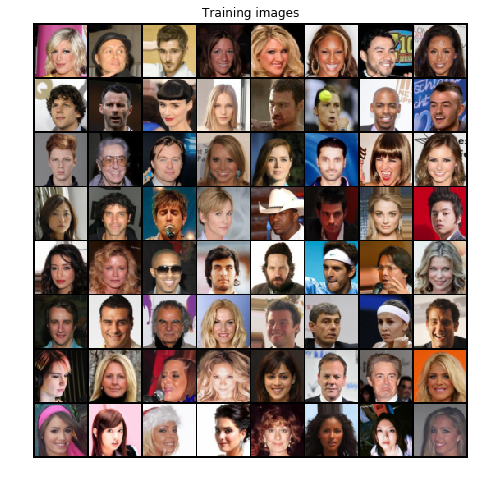

In [29]:
# visualizing the data

images,_ = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.title('Training images')
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

# Weight Initialization

In [30]:
def init_weight(model):
    name_class = model.__class__.__name__
    if name_class.find('Conv') != -1:
        nn.init.normal_(model.weight.data,0.0,0.02)
    elif name_class.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data,1.0,0.02)
        nn.init.constant_(model.bias.data,0)

# Discriminator

In [31]:
# Discriminator

nc = 3
ndf = 64

class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator,self).__init__()
        
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
                                   # input is (nc) x 64 x 64
                                  nn.Conv2d(nc,ndf,kernel_size=4,stride=2,padding=1,bias=False),
                                  nn.LeakyReLU(0.2,inplace=True),
                                   # input is (ndf) x 32 x 32
                                  nn.Conv2d(ndf,ndf*2,kernel_size=4,stride=2,padding=1,bias=False),
                                  nn.BatchNorm2d(ndf*2),
                                  nn.LeakyReLU(0.2,inplace=True),
                                   # input is (ndf*2 x 16 x 16
                                  nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
                                  nn.BatchNorm2d(ndf*4),
                                  nn.LeakyReLU(0.2,inplace=True),
                                   # input is (ndf*4) x 8 x 8
                                  nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
                                  nn.BatchNorm2d(ndf*8),
                                  nn.LeakyReLU(0.2,inplace=True),
                                   # input is (ndf*8) x 4 x 4
                                  nn.Conv2d(ndf*8,1,4,1,0,bias=False),
                                  nn.Sigmoid() )
        
    def forward(self,input):
            return self.main(input)
            
                                  

# Generator

In [32]:
# Generator
z = 100
ngf = 64

class Generator(nn.Module):
    def __init__(self,ngpu):
        super(Generator,self).__init__()
        
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
                                    # input is Z, going into a convolution
                                  nn.ConvTranspose2d(z,ngf*8,kernel_size=4,stride=1,padding=0,bias=False),
                                  nn.BatchNorm2d(ngf*8),
                                  nn.ReLU(inplace=True),
                                    # state size. (ngf*8) x 4 x 4
                                  nn.ConvTranspose2d(ngf*8,ngf*4,kernel_size=4,stride=2,padding=1,bias=False),
                                  nn.BatchNorm2d(ngf*4),
                                  nn.ReLU(inplace=True),
                                    # state size. (ngf*4) x 8 x 8
                                  nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
                                  nn.BatchNorm2d(ngf*2),
                                  nn.ReLU(inplace=True),
                                    # state size. (ngf*2) x 16 x 16
                                  nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
                                  nn.BatchNorm2d(ngf),
                                  nn.ReLU(inplace=True),
                                    # state size. (ngf) x 32 x 32
                                  nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
                                  nn.Tanh() )
        
    def forward(self,input):
            return self.main(input)
            

# Initializing models and applying weights

In [33]:
# initializing the model

# discriminator
netD = Discriminator(ngpu).to(device)
# generator
netG = Generator(ngpu).to(device)

if (device == 'cuda') and (ngpu>1):
    
    netD = nn.DataParallel(netD,list(range(ngpu)))
    netG = nn.DataParallel(netG,list(range(ngpu)))
    
# apply weight initializations

netD.apply(init_weight)
netG.apply(init_weight)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [34]:
# the loss function

criterion = nn.BCELoss()

real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(),lr=lr,betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(),lr=lr,betas=(beta1,0.999))

# Training the model

In [35]:
n_epochs = 15
Discriminator_losses = []
Generator_losses = []
f_noise = torch.randn(64,z,1,1,device=device)
img_list = []
iters = 0

for epoch in range(n_epochs):
    for i,data in enumerate(train_loader):
        
        # maximize log(D(x)) + log(1 - D(G(z)))
        
        # when loss is log D(x) real labels
        
        netD.zero_grad()
        images = data[0].to(device)
        b_size = images.size(0)
        label = torch.full((b_size,),real_label,device=device)
        output = netD(images).view(-1)
        errD_real = criterion(output,label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # when loss is log(1-D(G(z))) fake labels
        
        noise = torch.randn(b_size,z,1,1,device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        # do not update generator parameters
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output,label)
        errD_fake.backward()
        errD = errD_fake + errD_real
        D_G_z = output.mean().item()
        optimizerD.step()
        
        # generator portion maximize log(D(G(z)))
        
        netG.zero_grad()
        # real label for generator
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output,label)
        errG.backward()
        D_G_z1 = output.mean().item()
        
        optimizerG.step()
        
            
        # Save the losses  
        Discriminator_losses.append(errD)
        Generator_losses.append(errG)
        
        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(f_noise).detach().cpu()
            
            img_list.append(vutils.make_grid(fake,padding=2,normalize=True))
        
        iters+=1
            
   
    print('Epoch {}/{}|D_loss = {:0.3f}|G_loss= {:0.3f}|D_x = {:0.3f}|D_G_z = {:0.3f}|D_G_z1 = {:0.3f}'.format(epoch+1,n_epochs,
                                                                                                         errD.item(),errG.item()
                                                                                                         ,D_x,D_G_z,D_G_z1))
        
        

Epoch 1/15|D_loss = 0.713|G_loss= 5.836|D_x = 0.917|D_G_z = 0.402|D_G_z1 = 0.006
Epoch 2/15|D_loss = 0.726|G_loss= 4.386|D_x = 0.937|D_G_z = 0.422|D_G_z1 = 0.020
Epoch 3/15|D_loss = 1.108|G_loss= 0.828|D_x = 0.411|D_G_z = 0.041|D_G_z1 = 0.479
Epoch 4/15|D_loss = 0.628|G_loss= 1.677|D_x = 0.702|D_G_z = 0.200|D_G_z1 = 0.220
Epoch 5/15|D_loss = 0.835|G_loss= 4.402|D_x = 0.895|D_G_z = 0.454|D_G_z1 = 0.020
Epoch 6/15|D_loss = 0.540|G_loss= 1.929|D_x = 0.757|D_G_z = 0.183|D_G_z1 = 0.180
Epoch 7/15|D_loss = 0.541|G_loss= 2.841|D_x = 0.868|D_G_z = 0.287|D_G_z1 = 0.085
Epoch 8/15|D_loss = 0.415|G_loss= 3.772|D_x = 0.880|D_G_z = 0.224|D_G_z1 = 0.029
Epoch 9/15|D_loss = 0.581|G_loss= 1.716|D_x = 0.651|D_G_z = 0.055|D_G_z1 = 0.241
Epoch 10/15|D_loss = 0.412|G_loss= 5.371|D_x = 0.969|D_G_z = 0.283|D_G_z1 = 0.007
Epoch 11/15|D_loss = 0.272|G_loss= 3.468|D_x = 0.826|D_G_z = 0.052|D_G_z1 = 0.054
Epoch 12/15|D_loss = 0.179|G_loss= 3.955|D_x = 0.880|D_G_z = 0.035|D_G_z1 = 0.036
Epoch 13/15|D_loss = 0.75

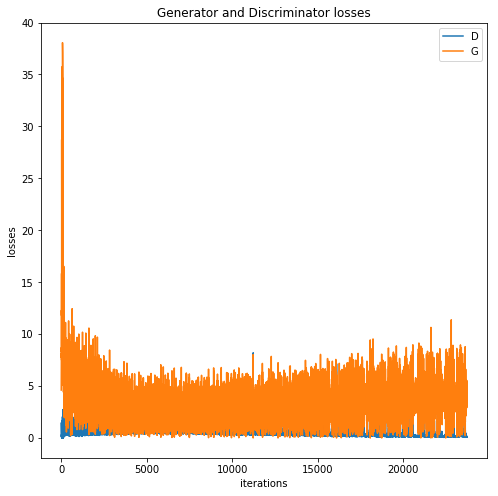

In [36]:
plt.figure(figsize=(8,8))
plt.title('Generator and Discriminator losses')
plt.plot(Discriminator_losses,label='D')
plt.plot(Generator_losses,label='G')
plt.xlabel('iterations')
plt.ylabel('losses')
plt.legend()
plt.show()

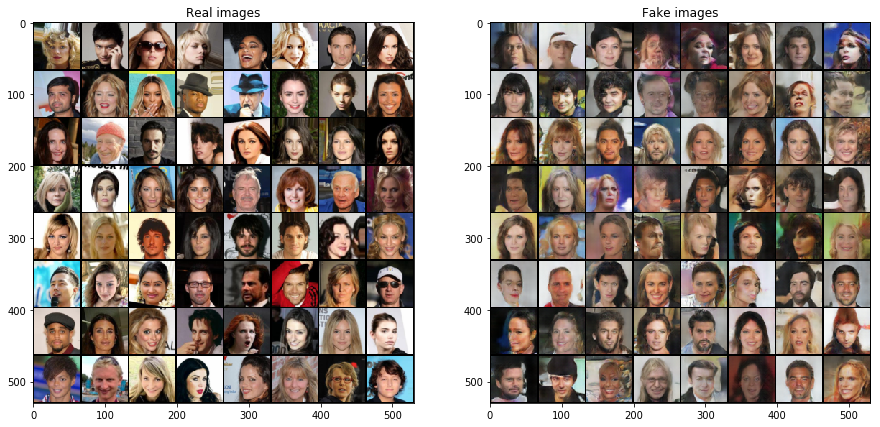

In [44]:
# Real Images and fake images

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Real images')
plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.title('Fake images')
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))